## plotting figures

In [59]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector, random_statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.compiler import transpile, assemble
from qiskit.circuit.library import TwoLocal
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd 
import numpy as np

In [24]:
# generate randomized statevectors for testing 
num_wavefunctions = 32
num_qubits = 4 
wave_functions = []

i = 0 
while i < num_wavefunctions: 
    wave_functions.append(random_statevector(dims = 2))
    i += 1

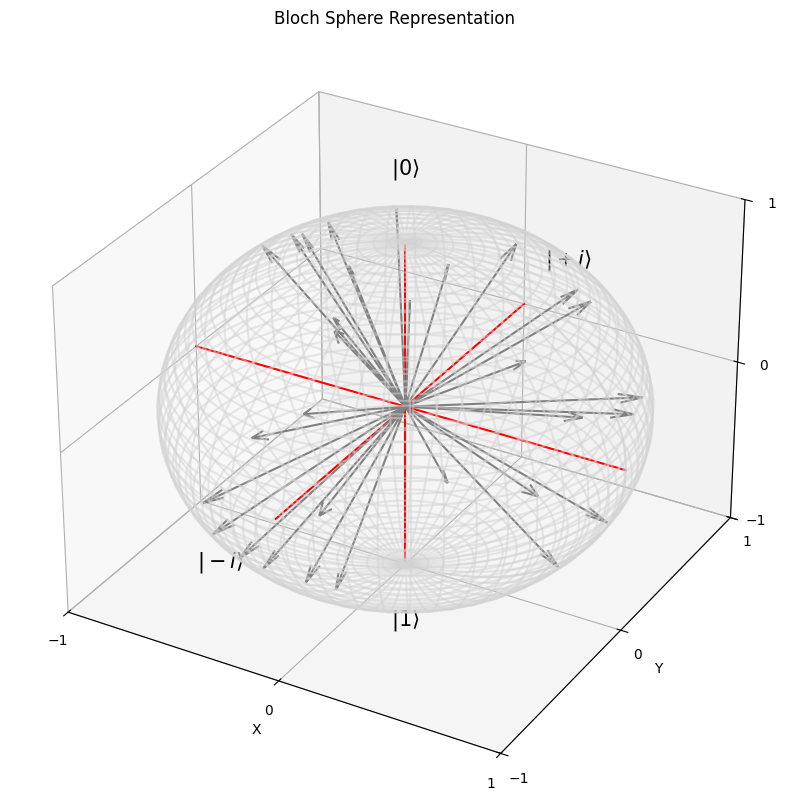

In [58]:
def statevector_to_bloch_vector(statevector):
   
    alpha, beta = statevector.data

    x = 2 * np.real(np.conj(alpha) * beta)
    y = 2 * np.imag(np.conj(alpha) * beta)
    z = np.abs(alpha)**2 - np.abs(beta)**2

    return np.array([x, y, z])

def plot_bloch_sphere(statevectors):
    
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot([-1, 1], [0, 0], [0, 0], color='r', linestyle='-')
    ax.plot([0, 0], [-1, 1], [0, 0], color='r', linestyle='-')
    ax.plot([0, 0], [0, 0], [-1, 1], color='r', linestyle='-')

    # Create a wireframe sphere
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))

    ax.plot_wireframe(x, y, z, color='lightgray', alpha=0.5)

    # Plot each statevector
    for sv in range(len(statevectors)):
        bloch_vector = statevector_to_bloch_vector(statevectors[sv])
        ax.quiver(0, 0, 0, bloch_vector[0], bloch_vector[1], bloch_vector[2], color='gray', arrow_length_ratio=0.1)

    # Set the axes properties
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])
    ax.set_zticks([-1, 0, 1])

    ax.text(0, 0, 1.4, r'$|0\rangle$', fontsize=15, ha='center')
    ax.text(0, 0, -1.4, r'$|1\rangle$', fontsize=15, ha='center')
    ax.text(0, 1.4, 0, r'$|+i\rangle$', fontsize=15, ha='center')
    ax.text(0, -1.4, 0, r'$|-i\rangle$', fontsize=15, ha='center')

    ax.set_title("Bloch Sphere Representation")

    plt.show()


plot_bloch_sphere(wave_functions)



/var/folders/38/q4k6mt054znfh_g97c8zyx1w0000gn/T/ipykernel_76523/1872705868.py:14: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = simulator.run(qobj).result()


Optimized Parameters:  [2.79640167 7.45475282 4.55050424 5.30034251 4.66941915 1.23549391]
Final Statevector:  Statevector([0.93439624+0.04349465j, 0.25051273-0.24951004j],
            dims=(2,))


/var/folders/38/q4k6mt054znfh_g97c8zyx1w0000gn/T/ipykernel_76523/1872705868.py:39: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = simulator.run(qobj).result()


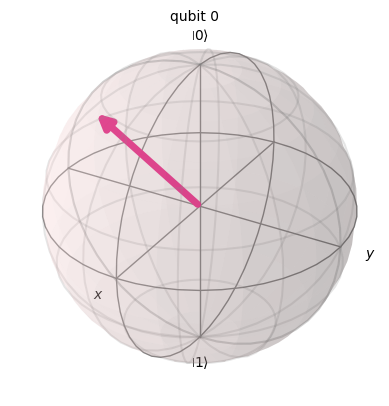

In [67]:
def ansatz(params, num_qubits=1, num_layers=2):
    qc = TwoLocal(num_qubits, ['ry', 'rz'], 'cz', reps=num_layers, insert_barriers=True)
    parameter_list = qc.parameters
    param_dict = {param: val for param, val in zip(parameter_list, params)}
    qc = qc.assign_parameters(param_dict)
    return qc

# Define the cost function
def cost_function(params, target_vectors):
    qc = ansatz(params, num_qubits=1, num_layers=len(params) // 3)
    simulator = Aer.get_backend('statevector_simulator')
    transpiled_qc = transpile(qc, simulator)
    qobj = assemble(transpiled_qc)
    result = simulator.run(qobj).result()
    statevector = result.get_statevector(qc)
    
    distances = []
    for vec in target_vectors:
        distances.append(np.linalg.norm(statevector - vec))
    
    # We aim to minimize the variance of these distances
    return np.var(distances)

target_vectors = wave_functions

# Initial parameters for the ansatz
num_layers = 2  # You can change the number of layers
initial_params = np.random.uniform(0, 2 * np.pi, 3 * num_layers)

# Perform the optimization
result = minimize(cost_function, initial_params, args=(target_vectors,), method='COBYLA')

# Output the results
optimized_params = result.x
final_circuit = ansatz(optimized_params, num_qubits=1, num_layers=num_layers)
simulator = Aer.get_backend('statevector_simulator')
transpiled_final_circuit = transpile(final_circuit, simulator)
qobj = assemble(transpiled_final_circuit)
result = simulator.run(qobj).result()
final_statevector = result.get_statevector(final_circuit)

print("Optimized Parameters: ", optimized_params)
print("Final Statevector: ", final_statevector)
plot_bloch_multivector(final_statevector)

/var/folders/38/q4k6mt054znfh_g97c8zyx1w0000gn/T/ipykernel_76523/3556344689.py:23: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = simulator.run(qobj).result()
/var/folders/38/q4k6mt054znfh_g97c8zyx1w0000gn/T/ipykernel_76523/3556344689.py:51: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = simulator.run(qobj).result()


Optimized Statevectors:
Statevector 1: Statevector([-0.02092074+0.j        , -0.78289542-0.62180148j],
            dims=(2,))
Statevector 2: Statevector([ 0.7073229 +0.j        , -0.21767254+0.67254218j],
            dims=(2,))
Statevector 3: Statevector([0.57014351+0.j        , 0.60233257-0.55868762j],
            dims=(2,))
Statevector 4: Statevector([-0.50656917+0.j        ,  0.28457222+0.81388349j],
            dims=(2,))
Statevector 5: Statevector([ 0.45151035+0.j        , -0.7052484 +0.54659226j],
            dims=(2,))
Statevector 6: Statevector([0.1992386 +0.j        , 0.94719292-0.25125594j],
            dims=(2,))
Statevector 7: Statevector([-0.60032498-0.j        , -0.72887141+0.32917531j],
            dims=(2,))
Statevector 8: Statevector([-0.00882035+0.j       , -0.11796233+0.9929789j],
            dims=(2,))
Statevector 9: Statevector([0.47727468+0.j        , 0.76604663+0.43055946j],
            dims=(2,))
Statevector 10: Statevector([-0.4704596 +0.j        , -0.80982118-

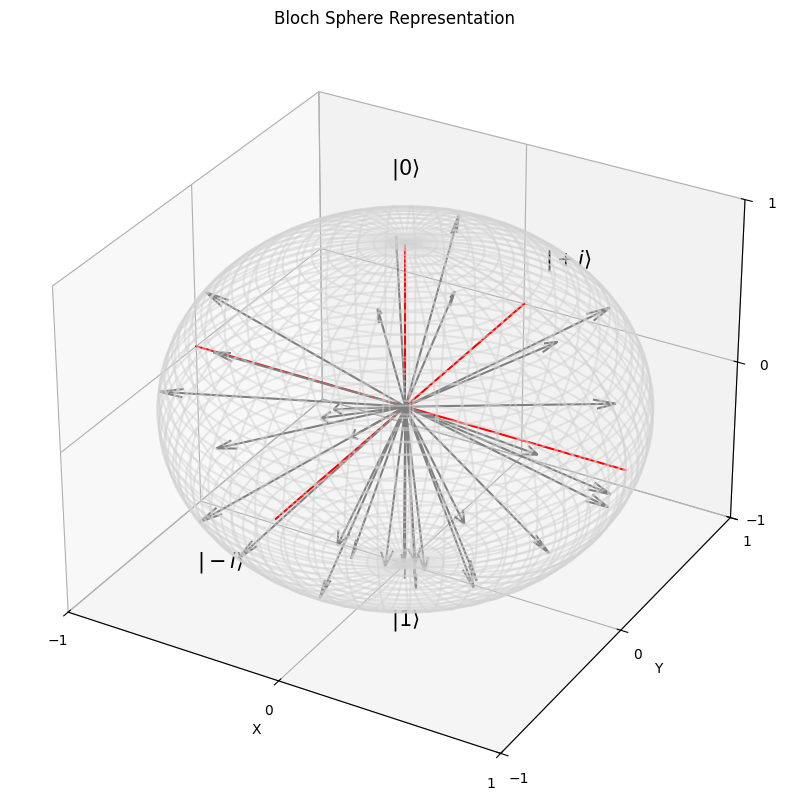

In [86]:
# Define initial target statevectors (randomly distributed on the Bloch sphere)
# Example: Randomly generate initial statevectors
num_statevectors = len(wave_functions)
initial_target_statevectors = wave_functions

# Define a function to create a quantum circuit for each statevector
def create_quantum_circuit(params):
    qc = QuantumCircuit(1)
    qc.u(params[0], params[1], params[2], 0)  # U3 gate: theta, phi, lambda
    return qc

# Define the cost function to encourage even distribution
def even_distribution_cost(params):
    total_cost = 0.0
    num_qubits = len(params) // 3
    statevectors = []

    for i in range(num_qubits):
        qc = create_quantum_circuit(params[3 * i : 3 * (i + 1)])
        simulator = Aer.get_backend('statevector_simulator')
        transpiled_qc = transpile(qc, simulator)
        qobj = assemble(transpiled_qc)
        result = simulator.run(qobj).result()
        statevector = result.get_statevector(qc)
        statevectors.append(statevector)

    for i in range(num_qubits):
        for j in range(i + 1, num_qubits):
            # Calculate squared distance between statevectors
            dist_ij = np.linalg.norm(statevectors[i] - statevectors[j])
            total_cost += 1.0 / (dist_ij**2)
    
    return total_cost

# Initialize parameters for the ansatz (3 parameters per statevector)
initial_params = np.random.uniform(0, 2 * np.pi, 3 * num_statevectors)

# Perform the optimization
result = minimize(even_distribution_cost, initial_params, method='COBYLA')

# Extract optimized parameters
optimized_params = result.x

# Update target statevectors based on optimized parameters
final_statevectors = []
for i in range(num_statevectors):
    qc = create_quantum_circuit(optimized_params[3 * i : 3 * (i + 1)])
    simulator = Aer.get_backend('statevector_simulator')
    transpiled_qc = transpile(qc, simulator)
    qobj = assemble(transpiled_qc)
    result = simulator.run(qobj).result()
    statevector = result.get_statevector(qc)
    final_statevectors.append(statevector)

# Print optimized statevectors
print("Optimized Statevectors:")
for i, statevector in enumerate(final_statevectors):
    print(f"Statevector {i+1}: {statevector}")

# Visualize final statevectors on Bloch sphere
plot_bloch_sphere(final_statevectors)